Эмбеддинги находятся в res/embeddings
- Сохранены отдельно эмбеддинги для текста, изображений
- Сохранены эмбеддинги, объединенные конкатенацией  (multimodal_embeddings.pkl)
- Сохранены эмбеддинги, полученные с помощью Feature Fusion
(fusion_embeddings.pkl)

Подключение Google Drive

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
cd /content/drive/MyDrive/ITMO/Classes/Information\ Retrieval/Labs/Lab\ 2.\ Content\ Vectorisation/

/content/drive/MyDrive/ITMO/Classes/Information Retrieval/Labs/Lab 2. Content Vectorisation


In [49]:
ls

data.csv      res/                  wb_content_vect_colab.ipynb  wb_scraper.ipynb
metadata.csv  tfidf_vectorizer.pkl  wb_scraper-Copy1.ipynb


In [50]:
import pandas as pd
import numpy as np

# Предобработка данных

In [51]:
metadata_path = 'metadata.csv'
metadata = pd.read_csv(metadata_path)
metadata.drop_duplicates(subset='id', inplace=True)
metadata['product_description'] = metadata['product_description'].apply(lambda x: ' '.join(x.split()[2:]))
metadata['merged_text'] = metadata.apply(lambda row: row['product_title'] + ' ' + row['product_description'], axis=1)
metadata['merged_text'] = metadata['merged_text'].apply(lambda x: x.replace(';','').lower().replace('*', '').replace('-', ''))
metadata.reset_index(inplace=True)
metadata.drop('index', axis=1, inplace=True)
metadata.head(5)

,id,product_title,product_description,filename,format,mode,resolution,filesize,retrieved,merged_text
0,209650955,Триммер садовый электрический для травы,Модель беспроводной; аккумуляторный; ручной Ти...,res/img/209650955.png,PNG,RGBA,"(246, 328)",171.35,1.711019e+09,триммер садовый электрический для травы модель...
1,77278318,Триммер аккумуляторный садовый дачный кусторез,Модель разборная модель Питание Аккумулятор (в...,res/img/77278318.png,PNG,RGBA,"(246, 328)",160.00,1.711020e+09,триммер аккумуляторный садовый дачный кусторез...
2,18565737,Триммер аккумуляторный ZITREK GreenCut 20 (20В...,Модель GreenCut 20 Гарантийный срок 1 год Тип ...,res/img/18565737.png,PNG,RGBA,"(246, 328)",17.67,1.711020e+09,триммер аккумуляторный zitrek greencut 20 (20в...
3,113066515,Триммер аккумуляторный садовый дачный кусторез,Модель разборная модель Питание Аккумулятор (в...,res/img/113066515.png,PNG,RGBA,"(246, 328)",128.90,1.711020e+09,триммер аккумуляторный садовый дачный кусторез...
4,151530782,Триммер-газонокосилка аккумуляторный ZITREK Gr...,Модель GreenCut 20 Pro Гарантийный срок 1 год ...,res/img/151530782.png,PNG,RGBA,"(246, 328)",128.13,1.711020e+09,триммергазонокосилка аккумуляторный zitrek gre...


Получаем текстовые строки следующего вида:

In [52]:
metadata['merged_text'][0]

'триммер садовый электрический для травы модель беспроводной аккумуляторный ручной тип аккумулятора liion емкость аккумулятора 1500 мач время работы от аккумулятора 120 минут'

### Токенизация текста

In [53]:
! pip install pymorphy2 > /dev/null 2>&1

In [54]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pymorphy2

morph_analyzer = pymorphy2.MorphAnalyzer()


def lemmatize(text, filter_stopwords = False):
    tokens = nltk.word_tokenize(text)

    if filter_stopwords:
      tokens = [word for word in tokens if word.lower() not in russian_stopwords and word.isalpha()]

    lemmatized_words = [morph_analyzer.parse(token)[0].normal_form for token in tokens]

    return lemmatized_words

nltk.download('punkt')
nltk.download('stopwords')

russian_stopwords = stopwords.words('russian')

metadata['merged_text'] = metadata['merged_text'].apply(lambda x: lemmatize(x))
metadata['merged_text'] = metadata['merged_text'].apply(lambda x: ' '.join(x))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Фильтрация текста лишила текст важной числовой информации о характеристиках товара. Такую информацию следует организовывать по-другому. Либо не применять фильтрацию по стоп-словам, т.к. описание товаров имеет схожую структуру. Не применяю фильтрацию, чтобы оставить числовые данные

In [55]:
metadata['merged_text'][0]

'триммер садовый электрический для трава модель беспроводный аккумуляторный ручной тип аккумулятор liion ёмкость аккумулятор 1500 мач время работа от аккумулятор 120 минута'

In [56]:
metadata.isna().sum()

id                     0
product_title          0
product_description    0
filename               0
format                 0
mode                   0
resolution             0
filesize               0
retrieved              0
merged_text            0
dtype: int64

# Векторизация текста

Создаем эмбеддинги с помощью tf-idf

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
text_vectors = tfidf_vectorizer.fit_transform(metadata['merged_text'])

text_embeddings = text_vectors.toarray()
text_embeddings.shape

(227, 636)

Сохраняем tfidf эмбеддинги

In [58]:
import joblib
joblib.dump(tfidf_vectorizer, 'res/embeddings/tfidf_vectorizer.pkl')

['res/embeddings/tfidf_vectorizer.pkl']

In [59]:
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = text_vectors.toarray()[0]

# Сортировка слов по значениям TF-IDF
sorted_keywords = [(_, word) for _, word in sorted(zip(tfidf_scores, feature_names), reverse=True)]

print("Ключевые слова:", sorted_keywords[:10])

Ключевые слова: [(0.43537138705354195, 'аккумулятор'), (0.32008979769356427, 'минута'), (0.32008979769356427, '120'), (0.2814109857951725, 'работа'), (0.2814109857951725, 'время'), (0.258785331262166, 'беспроводный'), (0.23615967672915963, 'ручной'), (0.20765472313681838, '1500'), (0.19748086483076785, 'трава'), (0.19446382034146856, 'liion')]


# Векторизация изображений

Используем SigLIP - https://huggingface.co/docs/transformers/en/model_doc/siglip

*демонстрирует лучшие результаты в сравнении с CLIP
<br><i>Zhai, X., Mustafa, B., Kolesnikov, A. and Beyer, L., 2023. Sigmoid loss for language image pre-training. In Proceedings of the IEEE/CVF International Conference on Computer Vision (pp. 11975-11986).</i>

In [60]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from transformers import CLIPProcessor, CLIPModel

In [61]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from transformers import AutoModel, AutoProcessor

model = AutoModel.from_pretrained("google/siglip-base-patch16-224")
processor = AutoProcessor.from_pretrained("google/siglip-base-patch16-224")

def encode_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    inputs = processor(images=image, return_tensors="pt", padding='max_length')
    image_features = model.get_image_features(**inputs)
    return image_features

image_embeddings = []
for index, row in metadata.iterrows():
    image_path = row['filename']
    image_embedding = encode_image(image_path)
    image_embedding = image_embedding.detach().numpy()
    image_embeddings.append(image_embedding[0])


In [62]:
image_embeddings = np.array(image_embeddings)
image_embeddings.shape

(227, 768)

In [63]:
image_embeddings_df = pd.DataFrame(image_embeddings)
image_embeddings_df.to_csv('res/embeddings/image_embeddings.csv')

In [64]:
image_embeddings_df

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.406477,0.484264,0.362383,-0.361617,0.367862,-0.345940,-0.314362,-0.277913,-0.520229,0.177259,...,0.012261,3.946063,-0.195392,0.186252,-0.488895,0.306398,0.529831,-0.013032,-0.359637,-0.177697
1,-0.054759,0.125280,0.102702,-0.286324,-0.038550,-0.284149,-0.016611,-0.153528,-1.024845,-0.369684,...,-0.146923,3.355812,-0.361554,0.310837,-0.285698,0.478276,0.315692,0.458624,0.187837,-0.134893
2,-0.496122,-0.086761,0.314986,-0.609928,0.907237,-0.156556,-0.147435,0.012920,-0.001185,0.115217,...,0.442288,4.016445,-0.284951,-0.036838,0.421496,0.302832,-0.307629,-0.026154,0.038623,-0.082541
3,0.034684,-0.035660,0.192627,-0.265398,0.080171,-0.450174,0.158838,-0.420661,-0.217382,0.022140,...,0.406908,4.070155,-0.540699,0.325117,-0.431352,0.375043,-0.131764,0.384281,-0.305212,-0.249911
4,0.060116,0.041796,-0.018798,-0.346257,-0.255146,0.445259,-0.362024,-0.640914,-0.357548,0.454868,...,0.205297,1.853132,-0.434038,-0.257191,0.710767,0.309495,-0.379672,0.667954,-0.488074,-0.350123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,-0.102839,0.230324,0.008673,-0.178402,0.223485,0.331221,-0.506685,-0.325277,-0.363362,0.312246,...,-0.429350,3.668763,-0.407078,-0.190715,-0.193539,0.566200,0.243793,0.284268,-0.957801,-0.152806
223,0.030433,-0.247124,0.174091,-0.049206,0.139765,-0.029399,-0.174786,0.134609,-0.366774,-0.072638,...,-0.612083,5.552631,0.053685,-0.300510,-0.114386,-0.475690,-0.070289,-0.006112,-0.061061,0.416166
224,-0.108061,0.148327,0.105001,-0.327554,0.247711,0.161864,-0.263172,-0.105571,-0.619548,0.458297,...,-0.494781,3.754027,-0.185701,0.030974,-0.287045,0.328841,0.453834,0.331367,-0.730853,-0.245204
225,0.004790,-0.265276,-0.330225,-0.179304,-0.768586,0.069846,-0.394298,-0.470475,-0.157948,0.993408,...,-0.122786,1.943149,0.067353,0.052030,-0.189314,0.349920,0.257479,-0.031607,-1.201042,0.136917


# Создание мультимодальных эмбеддингов

### Нормализация


In [65]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

text_embeddings_scaled = sc.fit_transform(text_embeddings)
image_embeddings_scaled = sc.fit_transform(image_embeddings)

### Объединение эмбеддингов текста и изображений

In [66]:
multimodal_embeddings = np.concatenate((text_embeddings_scaled, image_embeddings_scaled), axis=1)
multi_modal_embeddings_scaled = sc.fit_transform(multimodal_embeddings)

In [67]:
multimodal_embeddings

array([[-0.06651901, -0.19461563, -0.06651901, ..., -0.57642418,
         0.59462231, -0.40263996],
       [-0.06651901, -0.19461563, -0.06651901, ...,  0.86682498,
         1.81961668, -0.25205934],
       [-0.06651901, -0.19461563, -0.06651901, ..., -0.61657864,
         1.48574293, -0.06789022],
       ...,
       [-0.06651901, -0.19461563, -0.06651901, ...,  0.47742221,
        -0.23598994, -0.64012438],
       [-0.06651901, -0.19461563, -0.06651901, ..., -0.63326442,
        -1.28805578,  0.7041415 ],
       [-0.06651901, -0.19461563, -0.06651901, ...,  0.01569048,
         1.02058995,  0.18225788]])

In [68]:
multimodal_embeddings.shape

(227, 1404)

In [69]:
multimodal_embeddings_df = pd.DataFrame(multimodal_embeddings)
multimodal_embeddings_df.insert(loc=0, column='id', value = metadata['id'])
multimodal_embeddings_df.to_csv('res/embeddings/multimodal_embeddings.pkl')

# Feature Fusion

In [70]:
import tensorflow as tf
from tensorflow.keras import layers, Model

class FusionNetwork(Model):
    def __init__(self, num_text_features, num_image_features, fusion_units=1024):
        super(FusionNetwork, self).__init__()
        self.dense_text = layers.Dense(fusion_units, activation='relu')
        self.dense_image = layers.Dense(fusion_units, activation='relu')
        self.dense_fusion = layers.Dense(fusion_units, activation='relu')
        self.output_layer = layers.Dense(fusion_units)

    def call(self, text_embeddings, image_embeddings):
        text_features = self.dense_text(text_embeddings)
        image_features = self.dense_image(image_embeddings)
        fusion_features = self.dense_fusion(tf.concat([text_features, image_features], axis=-1))
        return self.output_layer(fusion_features)

fusion_network = FusionNetwork(num_text_features=636, num_image_features=768)

fusion_embeddings = fusion_network(text_embeddings_scaled, image_embeddings_scaled)


In [71]:
fusion_embeddings

<tf.Tensor: shape=(227, 1024), dtype=float32, numpy=
array([[ 0.260802  ,  0.40995866,  0.23933996, ...,  0.21820599,
        -0.09191005, -0.3832314 ],
       [ 0.01262552,  0.10672254, -0.21748945, ..., -0.33842054,
         0.369475  , -0.12223453],
       [ 0.06957497,  0.56227565, -0.28593588, ...,  0.07218176,
         0.48410267, -0.01548563],
       ...,
       [-0.9268559 ,  0.43328112, -0.1453098 , ...,  0.44581783,
         0.2684169 , -0.08634996],
       [ 0.20588166, -0.15365762, -0.27476346, ...,  0.29332632,
        -0.00445357,  0.26850915],
       [ 0.34238616,  0.3939777 , -0.0105042 , ...,  0.5829375 ,
         0.02542154, -0.44050023]], dtype=float32)>

In [72]:
fusion_embeddings_df = pd.DataFrame(fusion_embeddings)
fusion_embeddings_df.insert(loc=0, column='id', value = metadata['id'])

In [73]:
fusion_embeddings_df

,id,0,1,2,3,4,5,6,7,8,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,209650955,0.260802,0.409959,0.239340,-0.619762,0.451094,1.096070,0.016701,-0.148947,-0.132039,...,-0.407057,0.829125,-0.059635,-0.493543,0.381230,0.230100,0.945141,0.218206,-0.091910,-0.383231
1,77278318,0.012626,0.106723,-0.217489,0.090892,0.015345,0.592779,-0.271435,-0.719854,-0.204825,...,-0.430788,-0.177124,0.697999,0.254912,-0.403159,0.652763,0.079700,-0.338421,0.369475,-0.122235
2,18565737,0.069575,0.562276,-0.285936,-0.458114,-0.364354,0.112754,0.098563,-0.179648,-0.486273,...,0.059217,0.034143,0.286394,-0.142294,0.566790,-0.163012,0.801110,0.072182,0.484103,-0.015486
3,113066515,0.370798,0.060392,0.239372,0.091479,-0.137531,0.928292,-0.299249,-0.694156,0.203617,...,-0.547784,-0.219686,0.952841,0.343721,-0.668376,0.558183,-0.092246,-0.342277,0.409427,-0.505798
4,151530782,-0.445564,0.547956,-0.035611,0.337962,0.111511,0.708912,-0.514977,-0.466215,-0.479222,...,0.181264,0.270102,0.395595,-0.023698,-0.198529,0.396289,0.815714,0.322913,-0.196299,0.579387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,32788767,-0.103006,0.186803,0.202654,-0.934406,0.343135,0.696188,0.088361,-0.049413,0.303854,...,-0.560713,-0.099253,0.075297,-0.525133,0.360564,0.834161,0.150117,0.407750,0.734791,-0.463329
223,36485887,-0.443221,0.339527,-0.757484,0.040939,1.015309,0.696603,-0.279125,0.688413,0.742440,...,-0.047331,0.425964,0.437911,-0.122854,-0.140479,0.257612,-0.140049,0.834739,0.301959,0.318884
224,32790048,-0.926856,0.433281,-0.145310,-0.273582,0.548772,0.751743,-0.455407,-0.097173,0.346850,...,-1.130211,0.823072,0.568544,0.605506,0.703026,0.856371,0.032377,0.445818,0.268417,-0.086350
225,111124662,0.205882,-0.153658,-0.274763,0.188990,-0.085145,0.551512,-0.862136,-0.398393,-0.233226,...,0.242176,0.002679,0.136893,0.022354,-0.543034,0.027600,-0.162790,0.293326,-0.004454,0.268509


In [46]:
metadata.to_csv('res/embeddings/embeddings_metadata.csv')
fusion_embeddings_df.to_pickle('res/embeddings/fusion_embeddings.pkl')

# Проверка работы классификации изображений SigLIP

In [ ]:
from glob import glob
import random

test_descriptions = ['lawn mower',
                     'lawn trimmer',
                     'bicycle',
                     'woman',
                     'car']

test_descriptions = ['газонокосилка',
                     'триммер',
                     'велосипед',
                     'женщина',
                     'автомобиль']

seed = 12345

image_paths = glob('res/img/*.png')
random.seed(seed)
cur_image_paths = random.choices(image_paths, k=8)

test_images = []

for image_path in cur_image_paths:
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    test_images.append(image)

inputs = processor(text=test_descriptions, images=test_images, padding="max_length", return_tensors="pt")

with torch.no_grad():
  outputs = model(**inputs)

logits_per_image = outputs.logits_per_image
probs = torch.sigmoid(logits_per_image)

In [ ]:
probs

tensor([[5.3883e-06, 7.8492e-04, 7.3694e-06, 4.1434e-09, 5.7404e-06],
        [4.6693e-03, 3.1759e-01, 1.4949e-07, 1.3183e-07, 3.0562e-06],
        [3.5110e-05, 2.2273e-03, 3.4315e-07, 2.6252e-09, 1.1516e-05],
        [6.3297e-03, 2.0449e-01, 6.0898e-06, 1.5292e-09, 8.2865e-06],
        [1.7932e-02, 4.1196e-01, 6.4540e-07, 7.2472e-10, 4.7576e-06],
        [5.7602e-05, 4.0065e-04, 6.7353e-07, 8.3556e-10, 8.1261e-06],
        [2.3826e-04, 3.3706e-03, 1.0136e-06, 1.0113e-08, 1.4423e-06],
        [2.7739e-05, 3.5356e-04, 7.3079e-07, 5.8343e-10, 1.0537e-05]])

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
probs.shape[-1]

5

In [ ]:
top_probs, top_labels = probs.cpu().topk(5, dim=-1)

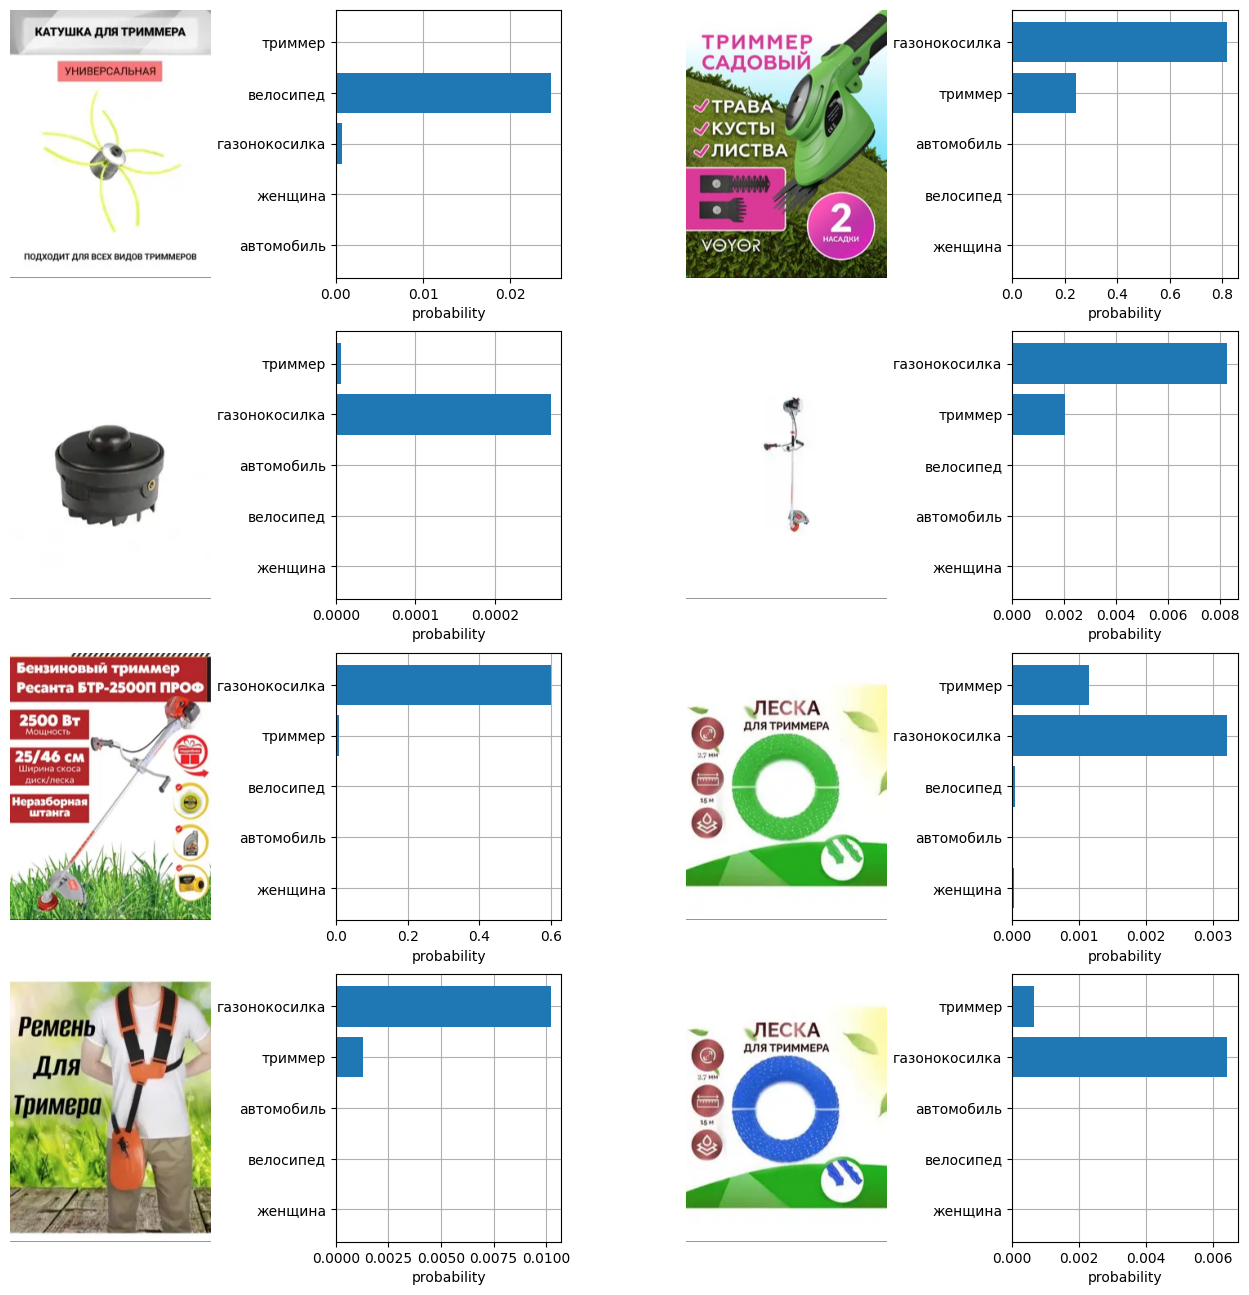

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

plt.figure(figsize=(16, 16))

for i, image in enumerate(test_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(probs.shape[-1])
    plt.grid()
    plt.barh(y, probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [test_descriptions[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

In [ ]:
from PIL import Image
import requests
from transformers import AutoProcessor, AutoModel
import torch

model = AutoModel.from_pretrained("google/siglip-base-patch16-224")
processor = AutoProcessor.from_pretrained("google/siglip-base-patch16-224")

#url = "http://images.cocodataset.org/val2017/000000039769.jpg"
#image = Image.open(requests.get(url, stream=True).raw)

image = tf.io.read_file('res/img/209650955.png')
image = tf.image.decode_png(image, channels=3)

texts = ["a photo of a lawn trimmer", "a photo of 2 dogs"]
# important: we pass `padding=max_length` since the model was trained with this
inputs = processor(text=texts, images=image, padding="max_length", return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

logits_per_image = outputs.logits_per_image
probs = torch.sigmoid(logits_per_image) # these are the probabilities
print(f"{probs[0][0]:.1%} that image 0 is '{texts[0]}'")

31.3% that image 0 is 'a photo of a lawn trimmer'
